In [1]:
from fetch_other_data import get_fed_fund, get_mtg_rate, get_market, get_census, get_irs
from fetch_zillow_data import get_zri, get_zhvi

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

import numpy as np

In [2]:
#grab zhvi data
zhvi = get_zhvi(update = False)

In [4]:
#grab mortgage data
mortgage_rate, mortgage_rate_annual = get_mtg_rate(False)

Updated by: freddiemac
date range: 1971-01-01 00:00:00 to 2018-04-01 00:00:00


In [5]:
#30-year mortgage rate offsets
mortgage_rate['30 FRM Rate 1'] = mortgage_rate['30 FRM Rate'].shift(1)
mortgage_rate['30 FRM Rate 6'] = mortgage_rate['30 FRM Rate'].shift(6)
mortgage_rate['30 FRM Rate 12'] = mortgage_rate['30 FRM Rate'].shift(12)
mortgage_rate['30 FRM Rate 24'] = mortgage_rate['30 FRM Rate'].shift(24)

#30-year mortgage month over month percentage changes, and offsets
mortgage_rate['30 FRM Rate pct_change'] = mortgage_rate['30 FRM Rate'].pct_change()
mortgage_rate['30 FRM Rate pct_change 1'] = mortgage_rate['30 FRM Rate pct_change'].shift(1)
mortgage_rate['30 FRM Rate pct_change 6'] = mortgage_rate['30 FRM Rate pct_change'].shift(6)
mortgage_rate['30 FRM Rate pct_change 12'] = mortgage_rate['30 FRM Rate pct_change'].shift(12)
mortgage_rate['30 FRM Rate pct_change 24'] = mortgage_rate['30 FRM Rate pct_change'].shift(24)

In [6]:
#find five zip codes that have higher # of data points
example_zips = list(zhvi[zhvi['Home Type'] == 'All Homes'].groupby('zip')['zhvi'].count().sort_values(ascending = False).index)[:5]

In [7]:
# dataframe with specific zip codes and 'Home Type' == 'All Homes'
temp1_df = zhvi[(zhvi['zip'].isin(example_zips)) & (zhvi['Home Type'] == 'All Homes')]

In [9]:
#possible target is also percentage changes
temp1_df['zhvi pct_change'] = temp1_df.groupby(['Home Type', 'zip']).zhvi.pct_change()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
#get the targets and features together
temp2_df = pd.merge(temp1_df, mortgage_rate[['30 FRM Rate', '30 FRM Rate 1',
                                             '30 FRM Rate 6', '30 FRM Rate 12',
                                             '30 FRM Rate 24', '30 FRM Rate pct_change',
                                             '30 FRM Rate pct_change 1',
                                             '30 FRM Rate pct_change 6',
                                             '30 FRM Rate pct_change 12',
                                             '30 FRM Rate pct_change 24']],
                    how = 'left', left_index = True, right_index = True)

In [11]:
print(temp2_df[(temp2_df['zip'] == '12077') & (temp2_df['Home Type'] == 'All Homes')].head())

            Home Type    zip      zhvi interp  zhvi pct_change  30 FRM Rate  \
1996-04-01  All Homes  12077  148800.0  False              NaN        7.925   
1996-05-01  All Homes  12077  149900.0  False         0.007392        8.070   
1996-06-01  All Homes  12077  150900.0  False         0.006671        8.320   
1996-07-01  All Homes  12077  151400.0  False         0.003313        8.245   
1996-08-01  All Homes  12077  151100.0  False        -0.001982        8.000   

            30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
1996-04-01          7.624         7.4750            8.32           8.316   
1996-05-01          7.925         7.3775            7.96           8.600   
1996-06-01          8.070         7.2000            7.57           8.400   
1996-07-01          8.320         7.0300            7.61           8.610   
1996-08-01          8.245         7.0750            7.86           8.510   

            30 FRM Rate pct_change  30 FRM Rate pct_change 1  \
1996

### Take a look if the features have any linear relationship with the target

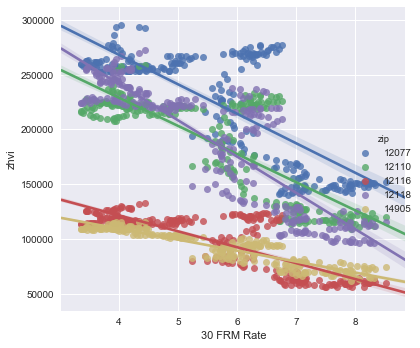

In [12]:
sns.lmplot(data = temp2_df, x = '30 FRM Rate', y = 'zhvi', hue = 'zip')
plt.tight_layout()
plt.show()

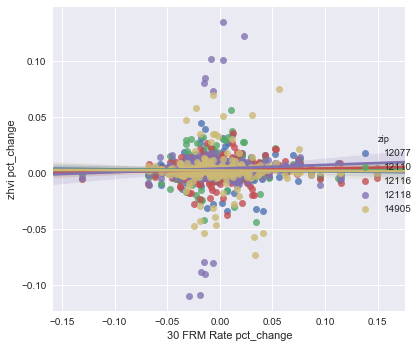

In [13]:
sns.lmplot(data = temp2_df, x = '30 FRM Rate pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()
plt.show()

14905


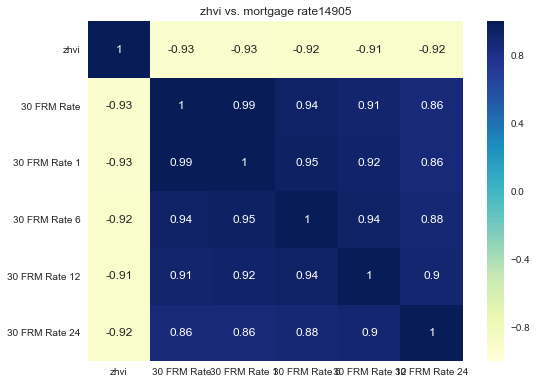

12077


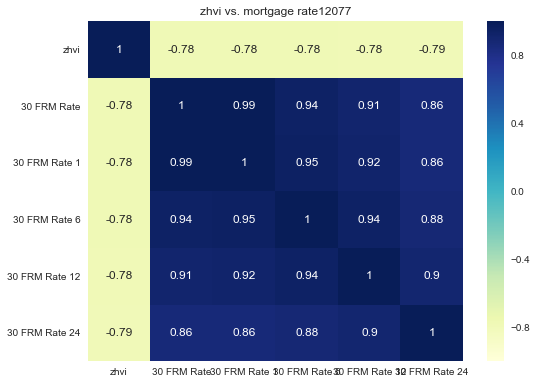

12118


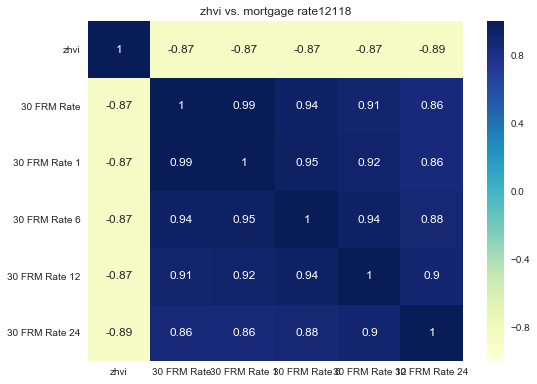

12116


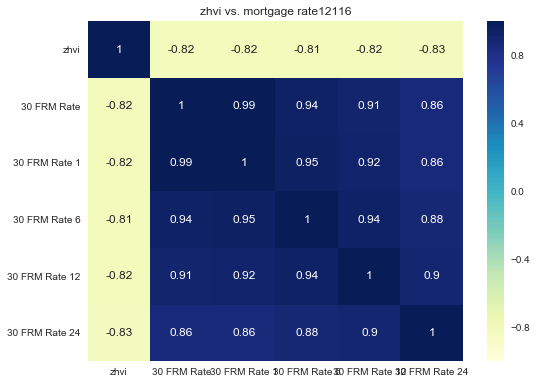

12110


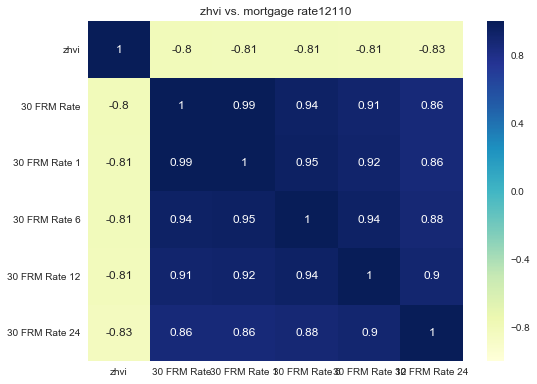

In [14]:
for zipcode in example_zips:
    print(zipcode)
    heatmap1 = temp2_df[temp2_df.zip == zipcode][['zhvi', '30 FRM Rate', '30 FRM Rate 1',
                                                  '30 FRM Rate 6', '30 FRM Rate 12',
                                                  '30 FRM Rate 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = "YlGnBu")
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. mortgage rate' + zipcode)
    plt.tight_layout()
    plt.show()

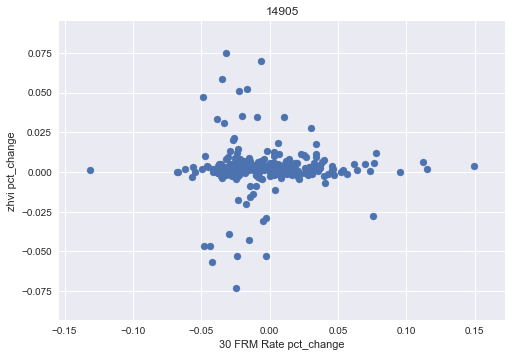

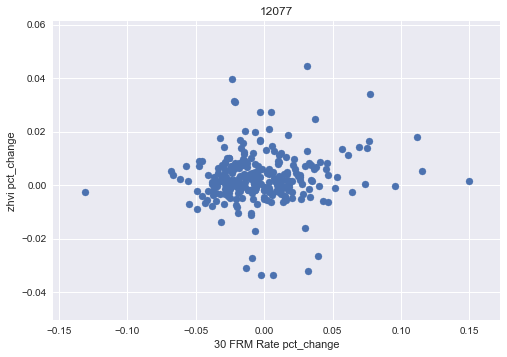

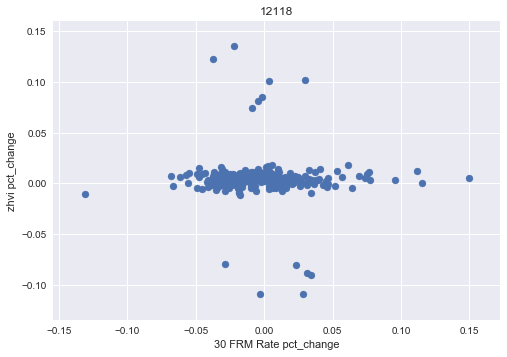

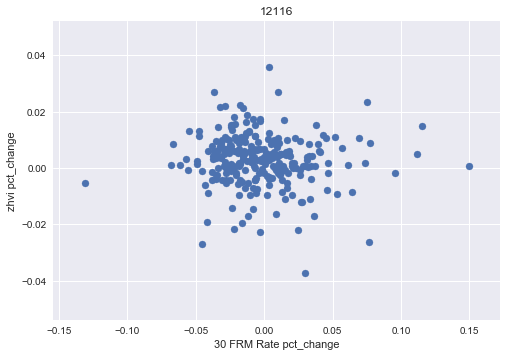

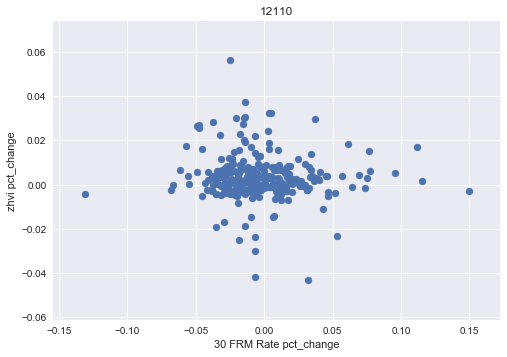

In [15]:
for zipcode in example_zips:
    plt.scatter(x = temp2_df[temp2_df.zip == zipcode]['30 FRM Rate pct_change 24'],
                y = temp2_df[temp2_df.zip == zipcode]['zhvi pct_change'])
    plt.title(zipcode)
    plt.xlabel('30 FRM Rate pct_change')
    plt.ylabel('zhvi pct_change')
    plt.show()

In [ ]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp2_df[temp2_df.zip == zipcode][['zhvi pct_change', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
                                                  '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
                                                  '30 FRM Rate pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = "YlGnBu")
    plt.yticks(rotation = 0) 
    plt.title('zhvi changes vs. mortgage rate changes' + zipcode)
    plt.tight_layout()
    plt.show()

In [ ]:
if True: #Target 'zhvi pct_change', trying to correct for skewness
    temp = temp2_df['zhvi pct_change'].dropna()
    lam = 0.0001
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))],
                loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))],
                loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))],
                loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    #plt.savefig('zhvi (% chg) Distribution.png')
    plt.show()